<a href="https://colab.research.google.com/github/sultanbst123/Zindi_Africa-Task-Mate-Kenyan-Sign-Language-Classification-Challenge/blob/main/Sign_Language_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sign Language Classification

## Library & File

In [ ]:
!nvidia-smi

Sun Feb 27 07:01:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8    27W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
pip install tensorflow_addons

     |████████████████████████████████| 1.1 MB 5.2 MB/s 


In [ ]:
pip install -U keras-cv-attention-models

     |████████████████████████████████| 388 kB 5.0 MB/s 
     |████████████████████████████████| 462 kB 45.0 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import gdown
import random 
import os

from zipfile import ZipFile
import matplotlib.pyplot as plt
import seaborn as sns 

#DL library
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras import layers

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras_cv_attention_models import *


import warnings
warnings.filterwarnings("ignore")

In [ ]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed()

In [ ]:
# ambil file dari gdrive, lalu extract ke file baru 

with ZipFile("/content/drive/MyDrive/Sign Language Classification Challenge/Kenya sign language classification.zip", "r") as zipobj:
     zipobj.extractall("sign language classification")

In [ ]:
train = pd.read_csv("/content/sign language classification/Train.csv")
test = pd.read_csv("/content/sign language classification/Test.csv")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6249 entries, 0 to 6248
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   img_IDS  6249 non-null   object
 1   Label    6249 non-null   object
dtypes: object(2)
memory usage: 97.8+ KB


In [ ]:
# ambil gambar dari gdrive, lalu extract ke file 

with ZipFile("/content/sign language classification/Images.zip", "r") as zipobj:
     zipobj.extractall("/content/sign language classification")

In [ ]:

# buat file baru yang berisi gambar coral

train["path"] = "/content/sign language classification/Images/" + train["img_IDS"] + ".jpg"
test["path"] = "/content/sign language classification/Images/" + test["img_IDS"] + ".jpg"

In [ ]:
train.head()

,img_IDS,Label,path
0,ImageID_33HMDMJ3,Temple,/content/sign language classification/Images/I...
1,ImageID_V5POEX4O,Church,/content/sign language classification/Images/I...
2,ImageID_89CCCCW6,Enough/Satisfied,/content/sign language classification/Images/I...
3,ImageID_GNJXOWX5,Me,/content/sign language classification/Images/I...
4,ImageID_7Q9LOP7R,Love,/content/sign language classification/Images/I...


In [ ]:
test.head()

,img_IDS,path
0,ImageID_USRB8QNG,/content/sign language classification/Images/I...
1,ImageID_SZ8D1ZJI,/content/sign language classification/Images/I...
2,ImageID_4OJO2F8J,/content/sign language classification/Images/I...
3,ImageID_IEE4XV0B,/content/sign language classification/Images/I...
4,ImageID_BP0O0WZ9,/content/sign language classification/Images/I...


## Explore Dataset

In [ ]:
# target

,Label
Enough/Satisfied,695
Mosque,695
Seat,695
Temple,694
Church,694
Me,694
Love,694
You,694
Friend,694


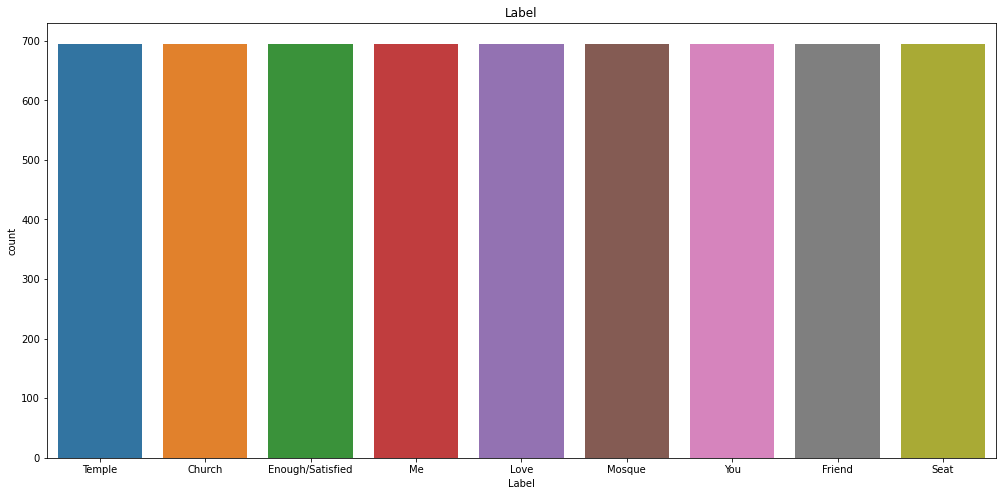

In [ ]:
plt.figure(figsize=(17, 8)) 
sns.countplot(train.Label)
plt.title("Label")

train.Label.value_counts().to_frame()

Perfect, teryata seimbang

In [ ]:
#image

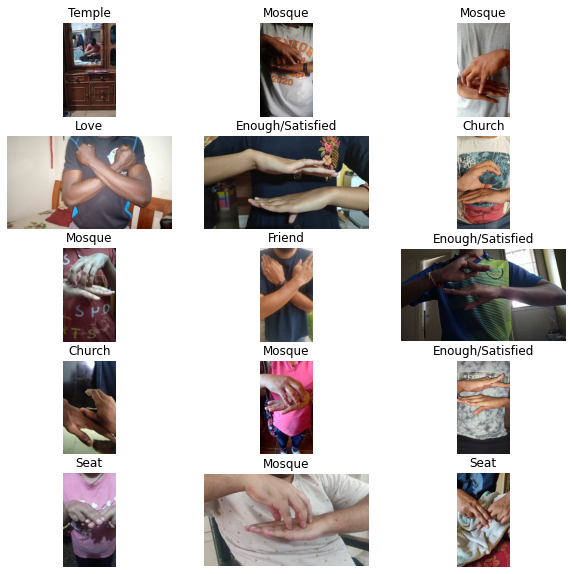

In [ ]:
# random image
random_img = np.random.choice(len(train), 15)

plt.figure(figsize=(10, 10))
for i in range(15): 
    plt.subplot(5, 3, i+1)
    img = random_img[i]
    my_img = plt.imread(train.path[img]) 
    plt.imshow(my_img) 
    plt.title(train.Label[img])
    plt.axis("off")
  
plt.show()

## Image pre processing & split

In [ ]:
# split pakai image data generator dataframe

In [ ]:

# ubah ke dari nama label ke diskrit, untuk mengambil nilai asli nya 
LC = LabelEncoder() 
train["new_label"] = LC.fit_transform(train.Label)

In [ ]:
BATCH_SIZE = 32
AUTO = tf.data.AUTOTUNE
IMG_SIZE = 224 # 384 # resize imahe

In [ ]:
x = train.path
y = tf.keras.utils.to_categorical(train.new_label) # ohe label
new_test = test.path

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.05, random_state=42)

x_train.shape, x_val.shape, y_train.shape, y_val.shape

((5936,), (313,), (5936, 9), (313, 9))

In [ ]:

# image test
@tf.function
def get_image(path):
    """Function loads image from a file and preprocesses it.
    :param path: Path to image file
    :return: Tensor with preprocessed image
    """
    image = tf.image.decode_jpeg(tf.io.read_file(path), channels=3)
    
    ## Resizing image
    image = tf.cast(tf.image.resize_with_pad(image, IMG_SIZE, IMG_SIZE), dtype=tf.int32)

    return image

# image train & validation
@tf.function
def process_dataset(path, label):

    """Function returns preprocessed image and label.
    :param path: Path to image file
    :param label: Class label
    :return: tf.Tensor with preprocessed image, numeric label
    """
    return get_image(path), label

In [ ]:
train_ds = tf.data.Dataset.from_tensor_slices((x_train,y_train))
train_ds = train_ds.map(process_dataset, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices((x_val,y_val))
val_ds = val_ds.map(process_dataset, num_parallel_calls=AUTO).batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices((new_test))
test_ds = test_ds.map(get_image, num_parallel_calls=AUTO).batch(BATCH_SIZE)

train_ds, val_ds, test_ds

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int32, name=None), TensorSpec(shape=(None, 9), dtype=tf.float32, name=None))>,
 <BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int32, name=None)>)

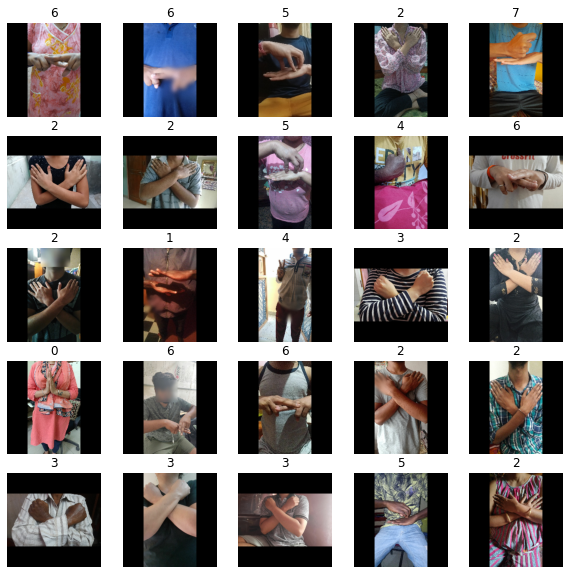

In [ ]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(image_batch[n])
    plt.title(np.argmax(label_batch[n].numpy()))
    plt.axis("off")

## Define Hyper parameters

In [ ]:
# Hyperparamters for fit 

EPOCHS = 10
INIT_LR = 1e-4
MAX_LR = 1e-2
Wd = 1e-5

#define learning rate scheduler
steps_per_epoch =  len(x_train) // BATCH_SIZE

clr = tfa.optimizers.Triangular2CyclicalLearningRate(
    initial_learning_rate=INIT_LR,
    maximal_learning_rate=MAX_LR,
    step_size= 3 * steps_per_epoch
)

#define optimizers 
ADAM = tf.keras.optimizers.Adam(learning_rate=clr)
SGD = tf.keras.optimizers.SGD(learning_rate=clr, momentum=0.9)
SGDW = tfa.optimizers.SGDW(learning_rate=clr, momentum=0.9,weight_decay=Wd)


ADABELIEF = tfa.optimizers.AdaBelief(learning_rate = clr, weight_decay = Wd)#recified == True default,  warmup 0.1
ADAMW = tfa.optimizers.AdamW(learning_rate = clr, weight_decay = Wd)

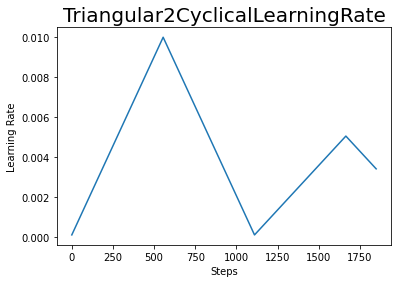

In [ ]:
step = np.arange(0, EPOCHS * steps_per_epoch)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.title("Triangular2CyclicalLearningRate", size=20)
plt.show()

## Deit(Data-Efficient Image Transformers) & Pit(Pooling-based Vision Transformers)

In [ ]:
!pip install tfimm
!pip install timm

In [ ]:
import tfimm

In [ ]:

data_augmentation = tf.keras.Sequential(
    [   
        #pakai normalization untuk convnext 
        layers.Normalization(mean=[0.485 * 255, 0.456 * 255, 0.406 * 255],
                             variance=[(0.229 * 255) ** 2, (0.224 * 255) ** 2, (0.225 * 255) ** 2]), # Reference: https://github.com/facebookresearch/ConvNeXt/blob/main/datasets.py
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2)
    ], 
    name="data_augmentation",
)

In [ ]:

# liat semua Pretrained model 

for i in tfimm.list_models():#pretrained="timm"): 
    print(i)

cait_m36_384
cait_m48_448
cait_s24_224
cait_s24_384
cait_s36_384
cait_xs24_384
cait_xxs24_224
cait_xxs24_384
cait_xxs36_224
cait_xxs36_384
convmixer_768_32
convmixer_1024_20_ks9_p14
convmixer_1536_20
convnext_base
convnext_base_384_in22ft1k
convnext_base_in22ft1k
convnext_base_in22k
convnext_large
convnext_large_384_in22ft1k
convnext_large_in22ft1k
convnext_large_in22k
convnext_small
convnext_tiny
convnext_xlarge_384_in22ft1k
convnext_xlarge_in22ft1k
convnext_xlarge_in22k
deit_base_distilled_patch16_224
deit_base_distilled_patch16_384
deit_base_patch16_224
deit_base_patch16_384
deit_small_distilled_patch16_224
deit_small_patch16_224
deit_tiny_distilled_patch16_224
deit_tiny_patch16_224
ecaresnet26t
ecaresnet50d
ecaresnet50t
ecaresnet101d
ecaresnet269d
ecaresnetlight
gmixer_12_224
gmixer_24_224
gmlp_b16_224
gmlp_s16_224
gmlp_ti16_224
ig_resnext101_32x8d
ig_resnext101_32x16d
ig_resnext101_32x32d
ig_resnext101_32x48d
mixer_b16_224
mixer_b16_224_in21k
mixer_b16_224_miil
mixer_b16_224_miil_

In [ ]:
input = layers.Input(shape=(224, 224, 3))

# augmentation  
x = data_augmentation(tfimm.create_preprocessing("pit_s_distilled_224", dtype="float32")(input)) 

# resnetrs model
ceit = tfimm.create_model("pit_s_distilled_224", nb_classes=0, pretrained="timm")(x) 
  
# add fc      
x1 = layers.GlobalAveragePooling1D()(ceit)
x1 = layers.Dropout(0.2)(x1)
output = layers.Dense(9, activation="softmax")(x1)

model = tf.keras.Model(inputs=input, outputs=output)

for layer in model.layers[6:7]:
    layer.trainable = False

#compile model 
model.compile(optimizer = SGDW,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), # tambahkan label_smoothing karena overfit 
              metrics = ["acc"])

model.summary()

## SwinTransformer & ConvNext

In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/swintransformertf')
from swintransformer import SwinTransformer

In [ ]:
input = layers.Input(shape=(224, 224, 3))

# augmentation  
x = data_augmentation(tf.keras.applications.imagenet_utils.preprocess_input(input,  mode="torch")) 

# sota model
cnvn = convnext.ConvNeXtBase(input_shape=(224, 224 ,3),num_classes = 0,pretrained="imagenet")(x)
#swin = SwinTransformer('swin_small_224', include_top=False, pretrained=True)(x) 

# add fc == swin     
#x1 = layers.GlobalAveragePooling2D()(swin)
#x1 = layers.Dropout(0.2)(x1) 

# add fc == convnext
x1 = layers.GlobalAveragePooling2D()(cnvn)
x1 = layers.Dropout(0.2)(x1)
x1 = layers.LayerNormalization(epsilon = 1e-6)(x1)
output = layers.Dense(9, activation="softmax")(x1)

model = tf.keras.Model(inputs=input, outputs=output)

for layer in model.layers[5:6]:
    layer.trainable = False

#compile model 
model.compile(optimizer = ADABELIEF,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1), # tambahkan label_smoothing karena overfit 
              metrics = ["acc"])

model.summary()

>>>> Load pretrained from: /root/.keras/models/convnext_base_224_imagenet.h5
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv_8 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 tf.nn.bias_add_4 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 tf.math.truediv_9 (TFOpLamb  (None, 224, 224, 3)      0         
 da)                                                             
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3

## Latih model

In [ ]:
set_seed() # seed everything

# only save best epoch
cp_path = "/tmp/checkpoint"
cb_checkpt = tf.keras.callbacks.ModelCheckpoint(cp_path, monitor = 'val_loss', verbose = 0,
                                 save_best_only = True,
                                 save_weights_only = True,
                                 mode = 'min')

history = model.fit(train_ds, validation_data=val_ds, 
                    epochs=EPOCHS, callbacks = [cb_checkpt],verbose=1)

model.load_weights(cp_path)

Epoch 1/10
186/186 [==============================] - 360s 2s/step - loss: 2.4232 - acc: 0.1459 - val_loss: 1.9907 - val_acc: 0.3323
Epoch 2/10
186/186 [==============================] - 329s 2s/step - loss: 1.9048 - acc: 0.3514 - val_loss: 1.5782 - val_acc: 0.5144
Epoch 3/10
186/186 [==============================] - 329s 2s/step - loss: 1.5594 - acc: 0.5264 - val_loss: 1.4499 - val_acc: 0.5911
Epoch 4/10
186/186 [==============================] - 330s 2s/step - loss: 1.3988 - acc: 0.6090 - val_loss: 1.3783 - val_acc: 0.6422
Epoch 5/10
186/186 [==============================] - 329s 2s/step - loss: 1.3037 - acc: 0.6611 - val_loss: 1.3524 - val_acc: 0.6422
Epoch 6/10
186/186 [==============================] - 329s 2s/step - loss: 1.2614 - acc: 0.6915 - val_loss: 1.3016 - val_acc: 0.6709
Epoch 7/10
186/186 [==============================] - 327s 2s/step - loss: 1.2465 - acc: 0.7060 - val_loss: 1.3181 - val_acc: 0.6645
Epoch 8/10
186/186 [==============================] - 328s 2s/step - 

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print(f"loss : {loss}") 
print(f"val accuracy : {round(accuracy * 100, 2)}%")

10/10 [==============================] - 16s 2s/step - loss: 1.3016 - acc: 0.6709
loss : 1.3015557527542114
val accuracy : 67.09%


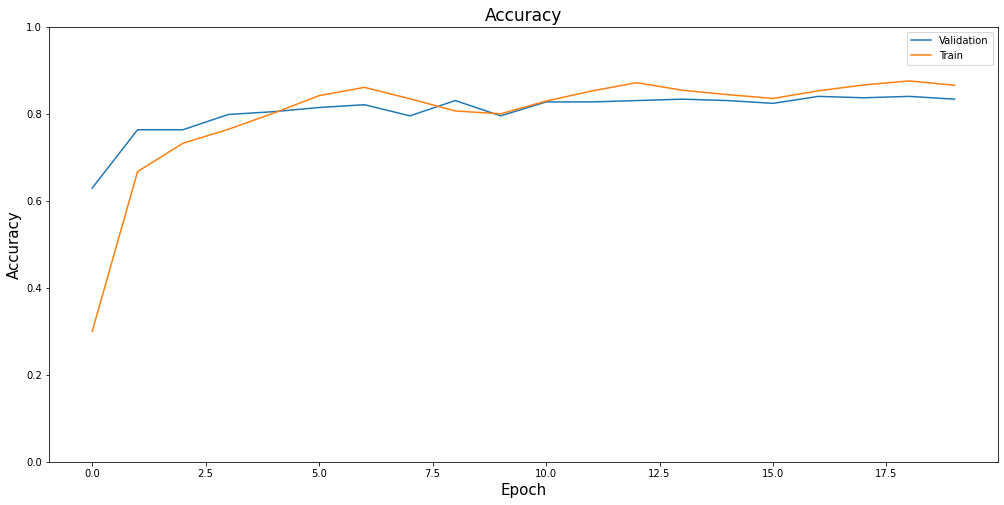

In [ ]:
#plot accuracy

plt.figure(figsize=(17, 8)) 

plt.plot(history.history["val_acc"],label="Validation")
plt.plot(history.history["acc"],label="Train")
plt.xlabel("Epoch", size=15) 
plt.ylabel("Accuracy", size=15)
plt.title("Accuracy", size=17)
plt.ylim([0,1.0]) 
plt.legend() 
plt.show()

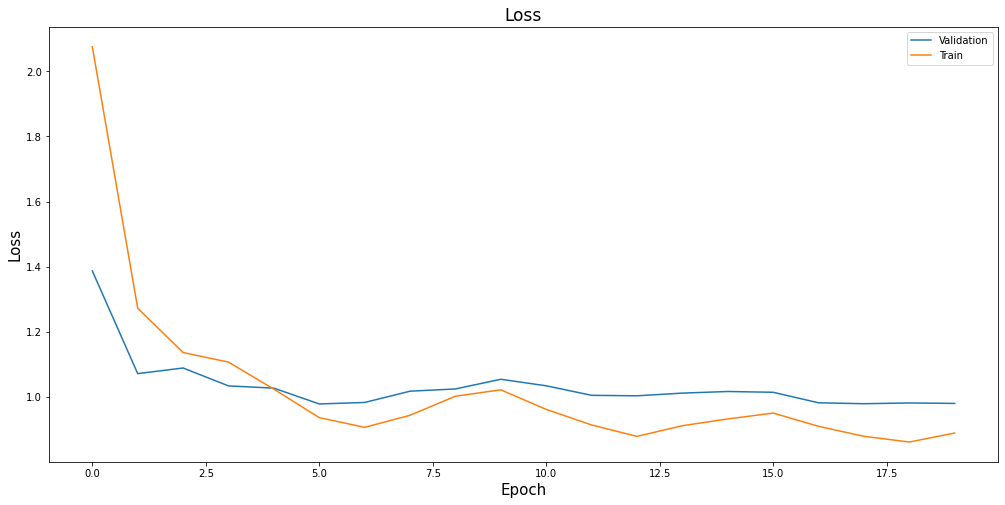

In [ ]:

#plot loss 

plt.figure(figsize=(17, 8)) 

plt.plot(history.history["val_loss"],label="Validation")
plt.plot(history.history["loss"],label="Train")
plt.xlabel("Epoch", size=15) 
plt.ylabel("Loss", size=15)
plt.title("Loss", size=17)
plt.legend() 
plt.show()

In [ ]:

# predict validation data 

y_true = model.predict(val_ds)

In [ ]:
classification_report(LC.inverse_transform(np.argmax(y_val,axis=1)),LC.inverse_transform(np.argmax(y_true,axis=1)))

'                  precision    recall  f1-score   support\n\n          Church       0.68      0.68      0.68        28\nEnough/Satisfied       0.71      0.69      0.70        32\n          Friend       0.94      0.83      0.88        35\n            Love       0.79      0.87      0.83        30\n              Me       0.81      0.91      0.86        43\n          Mosque       0.78      0.88      0.82        32\n            Seat       0.83      0.83      0.83        36\n          Temple       0.89      0.82      0.86        40\n             You       0.88      0.78      0.83        37\n\n        accuracy                           0.81       313\n       macro avg       0.81      0.81      0.81       313\n    weighted avg       0.82      0.81      0.81       313\n'

Text(0.5, 1.0, 'Confusion Matrix')

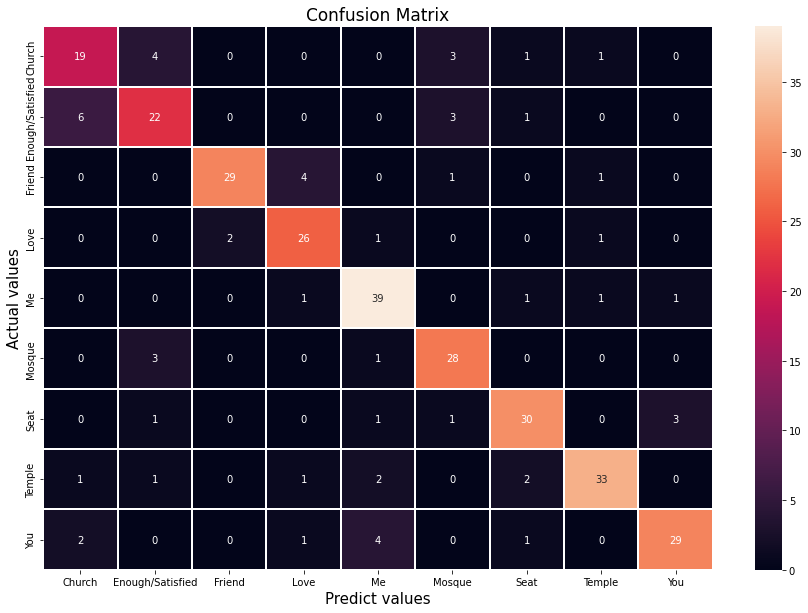

In [ ]:

# actual vs predict

cf_matrix = pd.crosstab(LC.inverse_transform(np.argmax(y_val,axis=1)),LC.inverse_transform(np.argmax(y_true,axis=1)))

plt.figure(figsize=(15,10)) 
sns.heatmap(cf_matrix, annot= True, linewidth=1, fmt = "d")
plt.xlabel("Predict values",size=15) 
plt.ylabel("Actual values",size=15)
plt.title("Confusion Matrix", size=17)

## make a submission

In [ ]:
test_ds

<BatchDataset element_spec=TensorSpec(shape=(None, 224, 224, 3), dtype=tf.int32, name=None)>

In [ ]:

# predict test dataset 

test_label = model.predict(test_ds)

In [ ]:

#ambil file submission

Sub = pd.read_csv("/content/sign language classification/SampleSubmission.csv")

In [ ]:
Sub

,img_IDS,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_USRB8QNG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ImageID_SZ8D1ZJI,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ImageID_4OJO2F8J,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ImageID_IEE4XV0B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ImageID_BP0O0WZ9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2674,ImageID_KZ958O2B,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2675,ImageID_UFNEWZ6U,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2676,ImageID_0IBAU19T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2677,ImageID_K6IAGP77,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
test_label

array([[0.07993712, 0.06764338, 0.12768547, ..., 0.13387868, 0.52268165,
        0.01690885],
       [0.13235535, 0.6347271 , 0.00824601, ..., 0.00411661, 0.01373178,
        0.0012146 ],
       [0.05453999, 0.16685362, 0.00456004, ..., 0.0834239 , 0.04265796,
        0.01403295],
       ...,
       [0.4754426 , 0.1945283 , 0.01287868, ..., 0.00543866, 0.2327445 ,
        0.0087493 ],
       [0.25575683, 0.17153886, 0.14994079, ..., 0.02220496, 0.07304644,
        0.02780034],
       [0.22200437, 0.031727  , 0.25597602, ..., 0.06927636, 0.0332993 ,
        0.030212  ]], dtype=float32)

In [ ]:
Sub.iloc[:,1:] = test_label

In [ ]:
Sub.sample(10)

,img_IDS,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
282,ImageID_NKZQHJWD,0.064698,0.028873,0.011979,0.006620,0.022359,0.018949,0.527296,0.159178,0.160048
1405,ImageID_DMRV5UN9,0.104241,0.708447,0.008471,0.013664,0.050611,0.037727,0.049427,0.005523,0.021888
807,ImageID_JA1D3RRJ,0.185034,0.111377,0.014467,0.002599,0.005758,0.033059,0.251711,0.377734,0.018260
2276,ImageID_4P93Q8SB,0.002594,0.000637,0.010112,0.062522,0.019829,0.005220,0.021303,0.802778,0.075006
1503,ImageID_VPX8OX42,0.087189,0.463135,0.034041,0.004321,0.018460,0.103976,0.098064,0.185683,0.005131
2190,ImageID_MDRJTBD8,0.037406,0.051089,0.023981,0.005863,0.033768,0.023289,0.460676,0.297046,0.066882
2490,ImageID_C25MQ3JT,0.417828,0.149585,0.014551,0.001080,0.009908,0.197282,0.162653,0.045358,0.001755
1170,ImageID_UR0ZOVR5,0.217669,0.078170,0.509917,0.077726,0.039739,0.050469,0.012435,0.008690,0.005183
479,ImageID_UCPS37IK,0.145705,0.050694,0.006412,0.003055,0.037376,0.228861,0.392926,0.121311,0.013660
414,ImageID_9U17610Q,0.023366,0.049825,0.005223,0.024578,0.351767,0.031666,0.043187,0.070507,0.399880


In [ ]:

# buat ke file csv

Sub.to_csv("submission_swin_tiny_224.csv", index=False)

In [ ]:

# simpan semua submission ke file gdrive 

!cp "/content/submission_swin_tiny_224.csv" "/content/drive/MyDrive/Sign Language Classification Challenge"

In [ ]:

# ambil semua file submission untuk melakukan ensemble

sota_1 = pd.read_csv("/content/drive/MyDrive/Sign Language Classification Challenge/submission_deitp16.csv")
sota_2 = pd.read_csv("/content/drive/MyDrive/Sign Language Classification Challenge/submission_pit.csv")
sota_3 = pd.read_csv("/content/drive/MyDrive/Sign Language Classification Challenge/submission_pit_ti_distilled_224.csv")
sota_4 = pd.read_csv("/content/drive/MyDrive/Sign Language Classification Challenge/submission_swin_tiny_224.csv")
sota_5 = pd.read_csv("/content/submission_convnextbase.csv")
sota_6 = pd.read_csv("/content/submissionconvtiny.csv")
sota_7 = pd.read_csv("/content/submission_deit_smallp16.csv")
sota_8 = pd.read_csv("/content/submission_pit_small.csv")
sota_9 = pd.read_csv("/content/drive/MyDrive/Sign Language Classification Challenge/submission_pit_xs_distilled_224.csv")

In [ ]:
ensemble =  (sota_1.iloc[:,1:].values +
             sota_2.iloc[:,1:].values +
             sota_3.iloc[:,1:].values +
             sota_4.iloc[:,1:].values +
             sota_5.iloc[:,1:].values +
             sota_6.iloc[:,1:].values +           
             sota_7.iloc[:,1:].values +
             sota_8.iloc[:,1:].values +
             sota_9.iloc[:,1:].values)/9

In [ ]:
ensemble

array([[0.12130318, 0.02335193, 0.08601312, ..., 0.02753979, 0.56117883,
        0.06528828],
       [0.09051536, 0.80466812, 0.00548083, ..., 0.00201092, 0.01293997,
        0.00357107],
       [0.08659318, 0.10141815, 0.00251753, ..., 0.03125758, 0.03337705,
        0.00614995],
       ...,
       [0.58041585, 0.1101211 , 0.01001875, ..., 0.01266811, 0.17843576,
        0.03887566],
       [0.19517716, 0.09026622, 0.17892434, ..., 0.04040235, 0.09554631,
        0.03318333],
       [0.0752785 , 0.01141492, 0.34637418, ..., 0.03041845, 0.04103777,
        0.04819962]])

In [ ]:
Sub.iloc[:,1:] = ensemble

In [ ]:
Sub

,img_IDS,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_USRB8QNG,0.121303,0.023352,0.086013,0.031680,0.016702,0.066942,0.027540,0.561179,0.065288
1,ImageID_SZ8D1ZJI,0.090515,0.804668,0.005481,0.001712,0.012869,0.066232,0.002011,0.012940,0.003571
2,ImageID_4OJO2F8J,0.086593,0.101418,0.002518,0.010291,0.005350,0.723046,0.031258,0.033377,0.006150
3,ImageID_IEE4XV0B,0.119407,0.249051,0.004168,0.001608,0.013840,0.377931,0.088529,0.119418,0.026047
4,ImageID_BP0O0WZ9,0.009104,0.001344,0.002882,0.001934,0.008263,0.005945,0.294609,0.039554,0.636364
...,...,...,...,...,...,...,...,...,...,...
2674,ImageID_KZ958O2B,0.209967,0.131956,0.017296,0.015153,0.051188,0.038059,0.032856,0.453868,0.049657
2675,ImageID_UFNEWZ6U,0.102100,0.027768,0.009259,0.006855,0.012976,0.169189,0.329515,0.100319,0.242017
2676,ImageID_0IBAU19T,0.580416,0.110121,0.010019,0.003539,0.023898,0.042028,0.012668,0.178436,0.038876
2677,ImageID_K6IAGP77,0.195177,0.090266,0.178924,0.261343,0.057924,0.047233,0.040402,0.095546,0.033183


In [ ]:

# buat ke file csv 

Sub.to_csv("ensemble.csv", index = False)

In [ ]:
#end